<a href="https://colab.research.google.com/github/radiosketch/edu/blob/master/Software%20Engineering/GUI%20Design/GIF%20Editor/developer_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## To Do:
- Convert the non-gui implementation in main.py to use a gui
- Use [tkinter documentation](https://docs.python.org/3/library/tk.html)
- Implement the following features:
    - **Captions & Adding Text**
    - **Preview Window**
    - **Common Functions Tab**
      - Resize, color grade, etc
      - Any function that can be applied to the entire gif without using the editor window.
    - **Resize**
        - Prompt for a new image size
        - See [ezgif](https://ezgif.com/resize) for inspiration
    - **Timeline Scrubbing**
        - View edits as highlighted sections on the timeline
        - Multiple edits are shown in horizontal strips, stacked on top of each other, with identifying colors, text, and relevant info
        - Drag the edges of a strip to change the duration
    - **Edit Durations**
        - AKA KEYFRAMES
        - Input the number of frames a particular edit should be duplicated across.
    - **Edit Transitions**
        - AKA KEYFRAME TRANSITIONS
        - Global edits can be set to transition over a number of frames
        - Transition interpolations (Linear, Cosine, Cubic)
    - **Copy/Paste Selection**
        - Selections can be copy/pasted from a single frame to multiple frames, or continuously sampled from another section of the frame, every frame.
        - Click the tool icon
        - Drag or Click two points, A & B, to select a rectangle.
            - Hold CTRL+Drag to get a perfect square
        - Drag the corners to edit the selection
            - Edits to the selection bbox can be made as keyframes, or as timeline-wide edits.
        - Press Enter to Select
    - **Paint Tools**
        - Onion Skin Option
        - Brush Size, Opacity, 
    - **Select Ellipse**
        - Hold CTRL+Drag to get a perfect circle
    - **Select Lasso**
        - Drag the mouse around to select something
    - **Color Select**
        - Threshold
    - **HSL**
        - Hue, Saturation, Lightness
    - **BC**
        - Brightness, Contrast
    - **Color LUT**
    - **Import GIF with URL**
    - **Export GIF**
- Stretch Goals
    - 3D Animated Templates
        - Cube Spin
- Come up with more ideas for features; refer to a dumb non-moving image editor like MS Paint, or [Pixlr E](https://pixlr.com/e/) for inspiration.
- [Flixier](https://editor.flixier.com) is an online video editor with many features pertainent to moving images. See a demo of the software [here](https://www.youtube.com/watch?v=nFL08KtpXws)
- Blender has a fleshed-out video editing environment, refer to that once most basic features are implemented.
- Check the feature list for competing software solutions, many of them can be found [here](https://www.movavi.com/learning-portal/best-gif-makers.html)

## Notes:
- Check docs on Pyinstaller to get more info on including asset files into the final .exe
    - The taskbar icon can only be set with Pyinstaller using ```pyinstaller --icon=icon.ico myscript.py```

## Testing Sandbox

### Example of binding events to tkinter.Canvas
Be aware: tkinter will not work when running the following code in the cloud. Use a local install of jupyter-lab.

In [1]:
from tkinter import *
root = Tk()

Creating a new class for the interactive canvas

In [2]:
class DrawCanvas(Canvas):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def paint(self, event):
        self.create_oval(event.x - 3, event.y - 3, event.x + 3, event.y + 3)

Initializing the newly extended canvas, packing it to the root, and binding the proper events to the canvas for painting:
- ```<1>``` Primary mouse button down 
- ```<B1-Motion>``` Motion of the mouse while the primary button is down  

See a full list of the tkinter events [here on effbot.org](https://web.archive.org/web/20201111211515id_/https://effbot.org/tkinterbook/tkinter-events-and-bindings.htm)

In [3]:
c = DrawCanvas(root, width=300, height=300, bg='#E8D7F1')
c.pack(expand=True, fill='both')
c.bind('<1>', c.paint)
c.bind('<B1-Motion>', c.paint)
root.mainloop()

Try clicking and dragging the mouse on the new window!

### Attempting to make an opimized zoom function for GIFCanvas
GIFCanvas is my custom class which extends tkinter.Canvas. The algorithm it uses to draw images is not very efficient, and my hope is that by blitting each layer as a precomputed PIL.Image the program will be more efficient during runtime.  

When zooming in and out, images need to be regenerated in real time. My current implementations have some framerate issues, but it should be possible to maintain a stable framerate. These are my attempts to build and test image generation algorithms.

In [4]:
from PIL import Image
import math

#### Image Generation Functions

While I don't have a full implementation of GIFCanvas.Layer, I can certainly test out some of the methods which will be commonly used for generating images pixel-by-pixel. One such algorithm is ```generate_tile```, which produces a PIL.Image which can be used as the background for a GIFCanvas.

In [5]:
# Generate a small section of background
def generate_tile(zoom=1, width=250, height=250):
  # Define grid colors
  lg = 255 // 2
  dg = 255 // 3

  # Starting by making a much smaller image
  # Making the grid cells the right size is done later using img.resize()
  # Using math.ceil so the dimensions are integers
  u_width = math.ceil(width / zoom)
  u_height = math.ceil(height / zoom)
  img = Image.new('RGB', (u_width, u_height), color=(dg, dg, dg))

  # Change every other pixel to get a checkboard
  pixels = img.load()
  k = 0
  for i in range(0, img.size[0]):
    for j in range(k, img.size[1], 2):
      pixels[i, j] = (lg, lg, lg)
    k = not k

  # Return the full size image, size rounded to fit grid cells evenly
  # Resampling with Image.BOX will not use any smoothing
  return img.resize((u_width * zoom, u_height * zoom), resample=Image.BOX)

#### Testing
Keeping the editor window running smoothly is crucial to a good experience; in this section I can test various image generation functions for speed.

In [6]:
import time
def timeit(func, *args, **kwargs):
  """
  Stopwatch for any function
  Returns the duration in seconds
  """
  start = time.time()
  out = func(*args, **kwargs)
  dt = time.time() - start
  return dt, out

Shown in the small example below, the method, ```generate_tile``` is passed into ```timeit```. The duration is returned alongside the output of the method, and the output image displayed.

Images generated by ```generate_tile``` look like a light grey & dark grey checkerboard grid, as seen in many photo editors.

Time: 0.001s (500, 250)


C:\Users\rad1osketxh\AppData\Local\Temp\ipykernel_5540\1288305059.py:24: DeprecationWarning: BOX is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BOX instead.
  return img.resize((u_width * zoom, u_height * zoom), resample=Image.BOX)


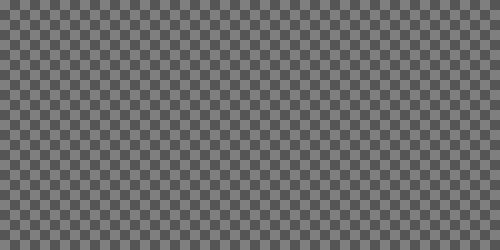

In [7]:
# Zoom is equivalent to the size of each grid cell in pixels
t, img = timeit(generate_tile, zoom=10, width=500, height=250)
print(f'Time: {round(t, 5)}s', img.size)
display(img)

A single datapoint isn't enough to spot efficiency gains, so let's graph the speed over a range of image sizes.

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import style
style.use('dark_background')

# rc is necessary to play animations in python notebooks
# not strictly necessary for my purposes here, but cool nonetheless
from matplotlib import rc
rc('animation', html='jshtml')

fps_30 = 1/30  # 30fps = one 30th of a second
fps_60 = 1/60  # 60fps = one 60th of a second

Image generation time can vary wildly, depending on the stability of the computer running the program. The methods below are used to calculate upper and lower bounds for generation time. Furthermore, they can be used to determine the resolution up to which each generation algorithm is sufficient for. 

If an algorithm can reliably generate 1000x1000 images at 60fps, it is sufficient for use in my editor. This method of analyzing and plotting will be very useful in finding the right algorithm for the job.

In [9]:
def min_max_slope(x, y, a, b):
  """
  Calculates slopes for two lines; a lower bound, and an upper bound

  Params:
    - x: x array
    - y: y array
    - a: first output of np.polyfit on a linear function
    - b: second output of np.polyfit on a linear function
  """
  max_dist_above = 0
  max_dist_below = 0

  min_slope = np.inf
  max_slope = 0

  # Calculate the line of best fit
  # These are just the y values that are useful for comparison
  lobf = a*np.array(x)+b

  for x_v, y_v, lobf_y in list(zip(x, y, lobf)):
    # Calculate the distance from the line of best fit, lobf
    distance = y_v - lobf_y
    # Update the positive fluctuations away from the line of best fit
    if distance > max_dist_above:
      # Project the current max slope to the current x value, then check again
      projected_max_dist_above = max_slope * x_v + b
      if distance > projected_max_dist_above and y_v > fps_60:
        max_slope = (y_v - b) / x_v
      max_dist_above = distance
    # Update the negative fluctuations away from the line of best fit
    if distance < max_dist_below and x_v > fps_60:
      projected_max_dist_below = min_slope * y_v + b
      if distance < projected_max_dist_below:
        min_slope = (y_v - b) / x_v
      max_dist_below = distance
  return min_slope, max_slope

def bounds(x, y):
  """
  Params: 
    - x: x array
    - y: y array
  Returns a, b, minimum_slope, maximum_slope, y_intercept
  Check documentation on np.polyfit for more info on a & b
  """
  a, b = np.polyfit(x, y, 1)
  min_s, max_s = min_max_slope(x, y, a, b)
  return a, b, min_s, max_s


#### Analyzing and Plotting Test Data

The following method will graph the efficiency of any grid generation function that takes the parameters:  
```(width: int, height: int: zoom: int)```

In [10]:
def test_generation_time(func):
  """
  func: The generation function to be tested
  Parameters of func MUST be the following
  (width: int, height: int, zoom: int)

  For maximum stress, the zoom is fixed at the minimum of 1
  """

  fig = plt.figure()
  ax = plt.axes()

  x = []
  y = []

  def animate(i, step):
    ax.clear()

    plt.title(f'Calculation time of {func.__name__}')
    ax.set_xlabel('Pixels Generated')
    ax.set_ylabel('Time Taken (s)')
    
    # X Data
    v = i * step
    x.append(v**2)
    
    # Y Data
    # Collecting time data from the generation function
    t, _img = timeit(func, width=v, height=v, zoom=1)
    y.append(t)
    
    # Perform analysis with the newly appended data
    a, b, min_s, max_s = bounds(x, y)
    
    # Keep the plot in view
    right_bound, = x[-1:]
    if right_bound != 0:
      ax.set_xlim(left=0, right=right_bound)
    
    # Placing a horizontal line at the 30 & 60 fps borders.
    f30 = ax.axhline(fps_30, color='red', alpha=0.5)
    f30.set_label('30 fps')
    f60 = ax.axhline(fps_60, color='green', alpha=0.5)
    f60.set_label('60 fps')
    
    # Record and analyze data if there is any
    if min_s != 0 and max_s != 0:
      
      # Placing a vertical line at the threshold for a stable framerate
      # Any resolution ahead of this line will have noticable stuttering
      max_for_30 = (fps_30 / max_s) - b
      ax.axvline(max_for_30, color='red', alpha=0.5)
      # Placing a vertical line at the max resolution to still hit 60fps
      # Any resolution behind this line will be quite stable
      max_for_60 = (fps_60 / max_s) - b
      ax.axvline(max_for_60, color='green', alpha=0.5)
      
      f30_max, = ax.plot(max_for_30, fps_30, marker='o', color='red', alpha=0.75)
      max_img_size = int(np.sqrt((fps_30 / max_s) - b))
      f30_max.set_label(f'Max Image Res. {max_img_size}x{max_img_size}')
      f60_max, = ax.plot(max_for_60, fps_60, marker='o', color='green', alpha=0.75)
      rec_img_size = int(np.sqrt((fps_60 / max_s) - b))
      f60_max.set_label(f'Recommended Image Res. {rec_img_size}x{rec_img_size}')
    
    # Plot the line of best fit for the data
    l, = ax.plot(x, a*np.array(x)+b, color='gold', alpha=0.75)
    max, = ax.plot(x, max_s*np.array(x)+b, color='lightcoral', alpha=0.5)
    min, = ax.plot(x, min_s*np.array(x)+b, color='lime', alpha=0.5)
    p = ax.plot(x, y, color='white')
    ax.legend()
    return p

  p = None
  m = 1000
  num_steps = 250
  for i in range(1, num_steps):
    p = animate(i, m // (num_steps - 1))
  p

The plot below displays the maximum and recommended image sizes for each algorithm. The maximum value assumes that any fps lower than 30 is not good, while the recommended value shoots for 60 fps.  

These values are highly dependent on the abilities of the computer, so implementing a benchmarking check could be helpful, especially for low-spec computers.

C:\Users\rad1osketxh\AppData\Local\Temp\ipykernel_5540\1288305059.py:24: DeprecationWarning: BOX is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BOX instead.
  return img.resize((u_width * zoom, u_height * zoom), resample=Image.BOX)
C:\Users\rad1osketxh\AppData\Local\Temp\ipykernel_5540\247258020.py:33: RankWarning: Polyfit may be poorly conditioned
  a, b, min_s, max_s = bounds(x, y)


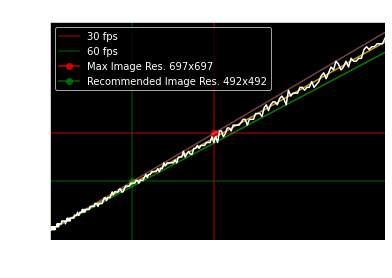

In [11]:
test_generation_time(generate_tile)

Notice that there is a linear relationship between the number of pixels generated and the time taken to generate. Keeping generation time low is imperative, so testing other methods may be useful.